# COVID-19 U.S. State-level and City-level Trends

In [1]:
%matplotlib inline

import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

# Plot configurations
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("darkgrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

### Run Parameters

In [2]:
# Path to input csvs
DATA_DIR = "csse_covid_19_daily_reports/"

# Date range to cover
MIN_DATE = "2020-03-22"
MAX_DATE = "2020-03-31"

# Add these back after rank filtering
STATE_INCLUDE_LIST = []
CITY_INCLUDE_LIST = []

# Exclude globally
STATE_EXCLUDE_LIST = ["New York", "New Jersey"]
CITY_EXCLUDE_LIST = []

# Manually set states or cities globally
STATE_OVERRIDE_LIST = []
CITY_OVERRIDE_LIST = []

# Limit to top n on max input date
CITY_LIMIT = 10
STATE_LIMIT = 10

### Sample Input Data

In [3]:
# Data sample pre-3/22

pd.read_csv(DATA_DIR + "03-21-2020.csv").head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21T20:43:02,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21T11:13:12,20610,1556,7635,32.4279,53.6880


In [4]:
# Data sample post-3/22

pd.read_csv(DATA_DIR + "03-22-2020.csv").head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"


### Data Loading and Transormation

In [5]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Lat": "Latitude",
            "Long_": "Longitude",
            "Last Update": "Last_Update",
            "Admin2": "City"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    agg_df["Date"] = pd.to_datetime(agg_df["Date"])
    
    # Limit date range
    agg_df = agg_df[agg_df["Date"].between(MIN_DATE, MAX_DATE)]
    
    # Filter for U.S. only
    agg_df = agg_df[agg_df["Country_Region"]=="US"]
    
    # Filter exclusion lists
    agg_df = agg_df[~agg_df.Province_State.isin(STATE_EXCLUDE_LIST)]
    agg_df = agg_df[~agg_df.City.isin(CITY_EXCLUDE_LIST)]
    
    if STATE_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.Province_State.isin(STATE_OVERRIDE_LIST)]
        
    if CITY_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.City.isin(CITY_OVERRIDE_LIST)]

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

agg_df = build_aggregate_df()

agg_df.head()

Num Rows: 29948
Total Dates: 10
Min Date: 2020-03-22 00:00:00
Max Date: 2020-03-31 00:00:00


,FIPS,City,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-03-23 23:19:34,34.223334,-82.461707,1.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-03-23
1,22001.0,Acadia,Louisiana,US,2020-03-23 23:19:34,30.295065,-92.414197,1.0,0.0,0.0,0.0,"Acadia, Louisiana, US",2020-03-23
2,51001.0,Accomack,Virginia,US,2020-03-23 23:19:34,37.767072,-75.632346,1.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-03-23
3,16001.0,Ada,Idaho,US,2020-03-23 23:19:34,43.452658,-116.241552,13.0,0.0,0.0,0.0,"Ada, Idaho, US",2020-03-23
4,19001.0,Adair,Iowa,US,2020-03-23 23:19:34,41.330756,-94.471059,1.0,0.0,0.0,0.0,"Adair, Iowa, US",2020-03-23


In [6]:
def build_state_df(agg_df):
    
    state_df = agg_df[["Date", "Province_State", "Confirmed"]]

    # Limit to top n locales
    include = (
        state_df[state_df.Date==MAX_DATE]
        .groupby('Province_State')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:STATE_LIMIT].index.to_list()
    
    include.extend(STATE_INCLUDE_LIST)
    
    print("Included states:\n", include)
    state_df = state_df[state_df['Province_State'].isin(include)]
    
    return state_df

state_df = build_state_df(agg_df)

state_df.head()

Included states:
 ['California', 'Michigan', 'Florida', 'Massachusetts', 'Illinois', 'Washington', 'Louisiana', 'Pennsylvania', 'Georgia', 'Texas']


,Date,Province_State,Confirmed
1,2020-03-23,Louisiana,1.0
10,2020-03-23,Illinois,1.0
17,2020-03-23,Pennsylvania,6.0
18,2020-03-23,Washington,1.0
23,2020-03-23,Florida,36.0


In [7]:
def build_city_df(agg_df):
    city_df = agg_df[["Date", "City", "Confirmed"]]
    
    # Limit to top n locales
    include = (
        city_df[city_df.Date==MAX_DATE]
        .groupby('City')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:CITY_LIMIT].index.to_list()
    
    include.extend(CITY_INCLUDE_LIST)
    
    print("Included cities:\n", include)
    city_df = city_df[city_df['City'].isin(include)]
    
    return city_df

city_df = build_city_df(agg_df)

city_df.head()

Included cities:
 ['Cook', 'Wayne', 'Los Angeles', 'King', 'Miami-Dade', 'Jefferson', 'Fairfield', 'Orleans', 'Unassigned', 'Oakland']


,Date,City,Confirmed
627,2020-03-23,Cook,0.0
628,2020-03-23,Cook,922.0
629,2020-03-23,Cook,0.0
901,2020-03-23,Fairfield,270.0
902,2020-03-23,Fairfield,0.0


In [8]:
def build_cumulative_df(locale_df, locale_column="Province_State"):

    cum_df = locale_df.groupby(by=["Date", locale_column]).sum()

    cum_df = cum_df.unstack()
    cum_df.columns = cum_df.columns.droplevel()
    cum_df.reset_index(level=0, inplace=True)
    
    return cum_df
    
cum_state_df = build_cumulative_df(state_df, "Province_State")

cum_state_df.head()

Province_State,Date,California,Florida,Georgia,Illinois,Louisiana,Massachusetts,Michigan,Pennsylvania,Texas,Washington
0,2020-03-22,1646.0,1004.0,621.0,1049.0,837.0,646.0,1035.0,509.0,643.0,1997.0
1,2020-03-23,2108.0,1227.0,772.0,1285.0,1172.0,777.0,1329.0,698.0,758.0,2221.0
2,2020-03-24,2538.0,1412.0,1026.0,1537.0,1388.0,1159.0,1793.0,946.0,955.0,2328.0
3,2020-03-25,2998.0,1682.0,1247.0,1865.0,1795.0,1838.0,2296.0,1260.0,1229.0,2591.0
4,2020-03-26,3899.0,2357.0,1525.0,2538.0,2304.0,2417.0,2845.0,1795.0,1563.0,3207.0


In [9]:
cum_city_df = build_cumulative_df(city_df, "City")

cum_city_df.head()

City,Date,Cook,Fairfield,Jefferson,King,Los Angeles,Miami-Dade,Oakland,Orleans,Unassigned,Wayne
0,2020-03-22,805.0,209.0,338.0,1040.0,407.0,227.0,277.0,451.0,495.0,481.0
1,2020-03-23,922.0,272.0,467.0,1170.0,536.0,278.0,329.0,569.0,578.0,643.0
2,2020-03-24,1194.0,388.0,524.0,1170.0,662.0,338.0,428.0,677.0,468.0,882.0
3,2020-03-25,1418.0,554.0,673.0,1359.0,812.0,400.0,543.0,830.0,613.0,1130.0
4,2020-03-26,1418.0,616.0,851.0,1577.0,1229.0,616.0,668.0,1000.0,1579.0,1401.0


In [10]:
def build_day_over_day_df(df, locale_column="Province_State"):
    df.sort_values("Date", inplace=True)
    df["_shifted"] = df.groupby(locale_column)["Confirmed"].transform(lambda x: x.shift())
    df["D/D Growth (Cases)"] = df["Confirmed"] - df["_shifted"]
    df["D/D Growth (%)"] = 100. * (df["D/D Growth (Cases)"] / df["_shifted"])
    df.drop(["_shifted"], axis=1, inplace=True)

    return df

day_over_day_state_df = build_day_over_day_df(state_df, "Province_State")

day_over_day_state_df.head()

,Date,Province_State,Confirmed,D/D Growth (Cases),D/D Growth (%)
23316,2020-03-22,Florida,2.0,NaN,NaN
23461,2020-03-22,Georgia,4.0,NaN,NaN
23460,2020-03-22,Georgia,4.0,0.0,0.0
23459,2020-03-22,Georgia,4.0,0.0,0.0
23458,2020-03-22,Georgia,4.0,0.0,0.0


In [11]:
day_over_day_city_df = build_day_over_day_df(city_df, "City")

day_over_day_city_df.head()

,Date,City,Confirmed,D/D Growth (Cases),D/D Growth (%)
23443,2020-03-22,Unassigned,36.0,NaN,NaN
24093,2020-03-22,Unassigned,8.0,-28.0,-77.777778
24031,2020-03-22,Jefferson,25.0,NaN,NaN
24030,2020-03-22,Unassigned,39.0,31.0,387.500000
23998,2020-03-22,Jefferson,71.0,46.0,184.000000


In [12]:
def build_normalized_state_df(cum_df, start_n=200):
    normalized_df = pd.DataFrame(columns=["Province_State", "Confirmed"])

    for state in cum_df.columns[1:]:
        df = cum_df[state].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["Province_State"] = state
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "Province_State")
        
    return normalized_df
        
normalized_state_df = build_normalized_state_df(cum_state_df)
    
normalized_state_df.head()

Province_State,Date,California,Florida,Georgia,Illinois,Louisiana,Massachusetts,Michigan,Pennsylvania,Texas,Washington
0,0,1646.0,1004.0,621.0,1049.0,837.0,646.0,1035.0,509.0,643.0,1997.0
1,1,2108.0,1227.0,772.0,1285.0,1172.0,777.0,1329.0,698.0,758.0,2221.0
2,2,2538.0,1412.0,1026.0,1537.0,1388.0,1159.0,1793.0,946.0,955.0,2328.0
3,3,2998.0,1682.0,1247.0,1865.0,1795.0,1838.0,2296.0,1260.0,1229.0,2591.0
4,4,3899.0,2357.0,1525.0,2538.0,2304.0,2417.0,2845.0,1795.0,1563.0,3207.0


In [13]:
def build_normalized_city_df(cum_df, start_n=100):
    normalized_df = pd.DataFrame(columns=["City", "Confirmed"])

    for city in cum_df.columns[1:]:
        df = cum_df[city].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["City"] = city
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "City")
        
    return normalized_df
        
normalized_city_df = build_normalized_city_df(cum_city_df)
    
normalized_city_df.head()

City,Date,Cook,Fairfield,Jefferson,King,Los Angeles,Miami-Dade,Oakland,Orleans,Unassigned,Wayne
0,0,805.0,209.0,338.0,1040.0,407.0,227.0,277.0,451.0,495.0,481.0
1,1,922.0,272.0,467.0,1170.0,536.0,278.0,329.0,569.0,578.0,643.0
2,2,1194.0,388.0,524.0,1170.0,662.0,338.0,428.0,677.0,468.0,882.0
3,3,1418.0,554.0,673.0,1359.0,812.0,400.0,543.0,830.0,613.0,1130.0
4,4,1418.0,616.0,851.0,1577.0,1229.0,616.0,668.0,1000.0,1579.0,1401.0


In [14]:
def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    
    for column in y:
        positions[column] = df[df[column].notnull()][column].values[-1] - 0.5  

    def push():
        """
        ...by putting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 2.5:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .1
                            positions[column2] += .1
                        else:
                            positions[column1] += .1
                            positions[column2] -= .1
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

In [15]:
def plot_case_growth(df):
    plot_df = df.copy()
    x = 'Date'
    y = plot_df.columns.tolist()[1:]
    
    f, ax = plt.subplots(figsize=(14, 14))        
    cmap = plt.cm.get_cmap('Dark2', len(y))
    
    # Generate positions
    positions = legend_positions(plot_df, y)
    
    for i, (column, position) in enumerate(positions.items()):

        # Get a color
        color = cmap(float(i)/len(positions))
        # Plot each line separatly so we can be explicit about color
        ax = plot_df.plot(x=x, y=column, legend=False, ax=ax, color=color)

        # Add the text to the right
        plt.text(
            plot_df[x][plot_df[column].last_valid_index()],
            position, column, fontsize=12,
            color=color # Same color as line
        )
    ax.set_ylabel('Cumulative Confirmed Cases')
    
    if plot_df.Date.dtype == "int":
        ax.set(xlim=(0, plot_df.Date.max() + 1))
        ax.set_xlabel('Num Days')
    else:
        ax.set(xlim=(MIN_DATE, plot_df.Date.max() + pd.DateOffset(days=1)))

    sns.despine()

## Data Visualization

### Cumulative Cases By State

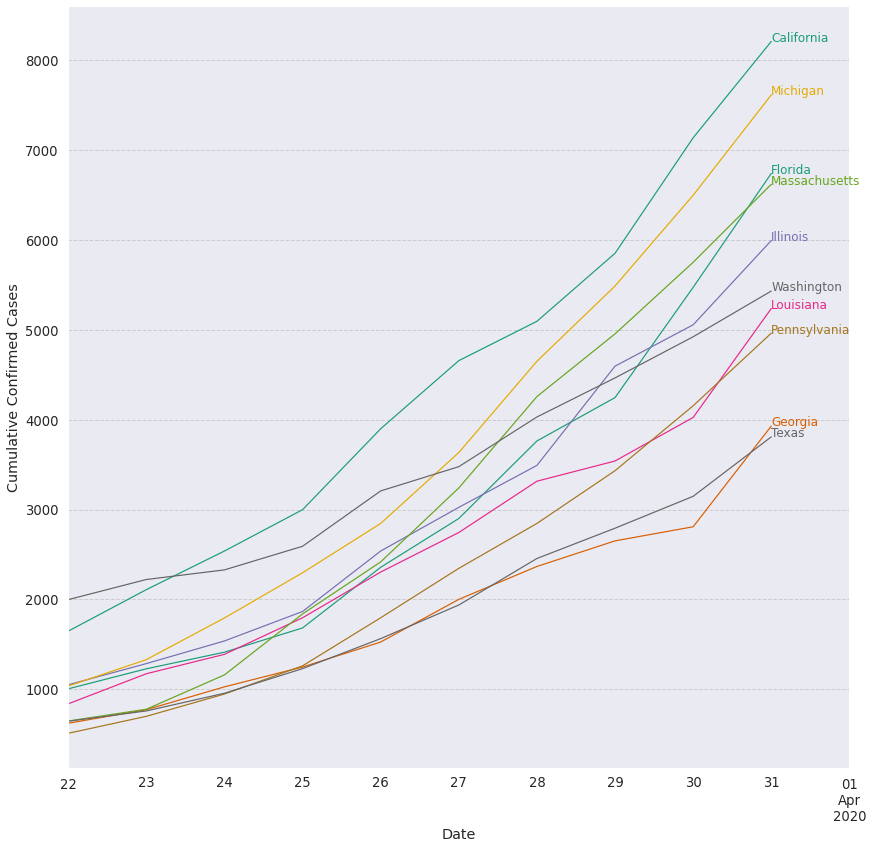

In [16]:
plot_case_growth(cum_state_df)

### Cumulative Cases By State (Normalized Start Date)

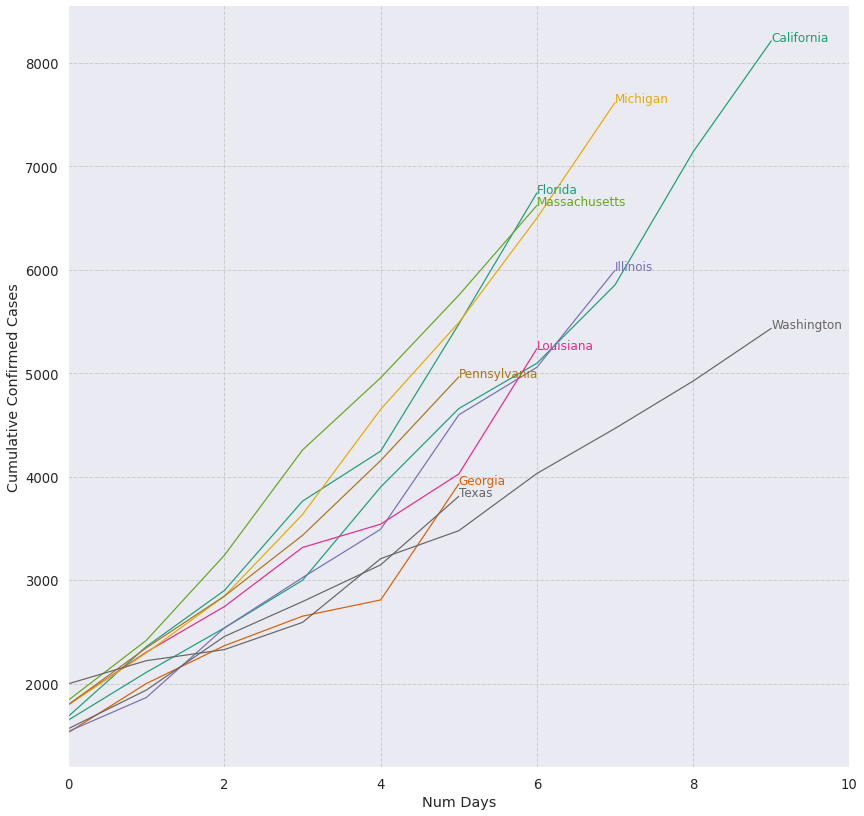

In [17]:
plot_case_growth(build_normalized_state_df(cum_state_df, start_n=1500))

### Cumulative Cases By City

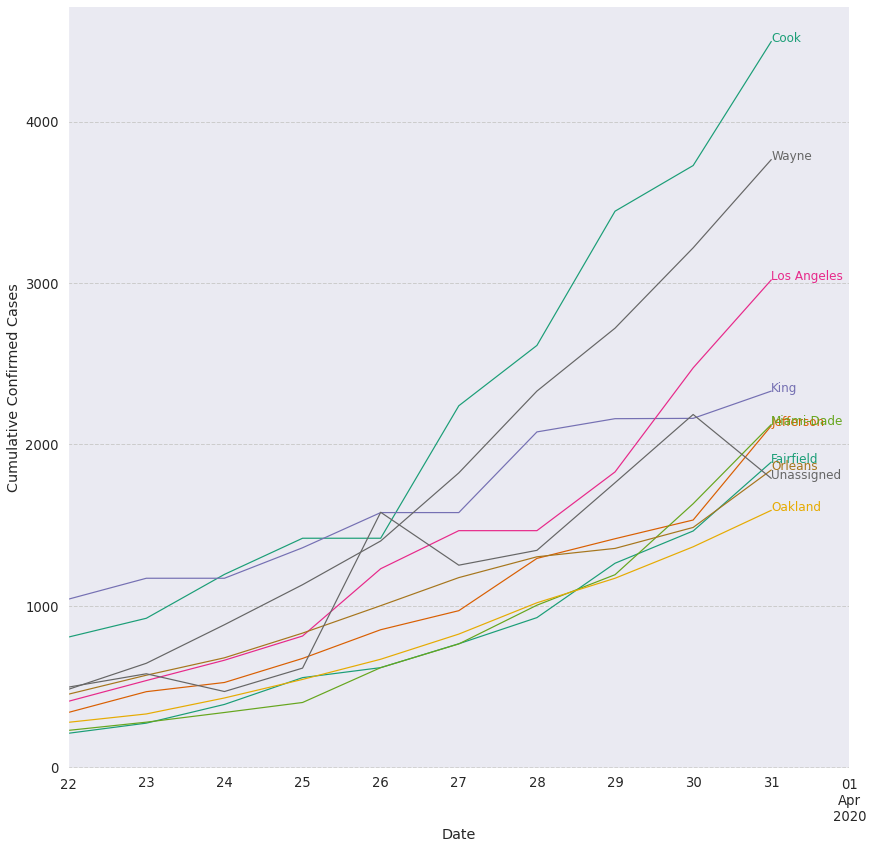

In [18]:
plot_case_growth(cum_city_df)

### Cumulative Cases By City (Normalized Start Date)

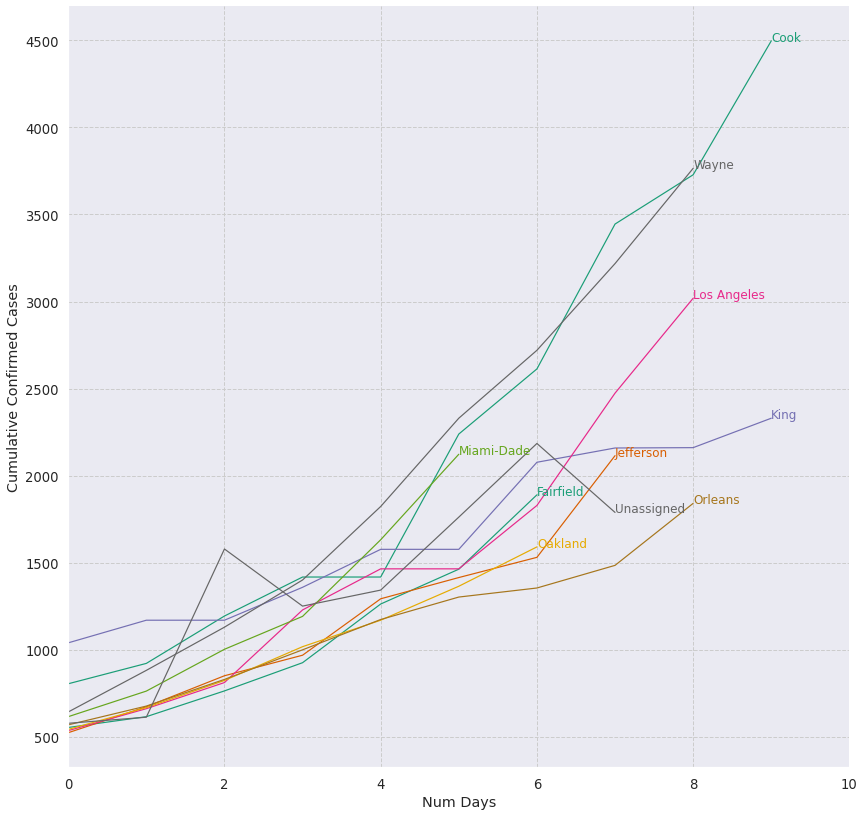

In [19]:
plot_case_growth(build_normalized_city_df(cum_city_df, start_n=500))